In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.td3 import TD3
from rl_hockey.common import utils

# Training (shooting)

In [2]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

o_space = env.observation_space
ac_space = env.action_space

In [3]:
state, info = env.reset()

In [4]:
state

array([-3.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.45303965, -1.42876887,  0.        ,  0.        ,
        0.        ,  0.        , -1.33486056, -0.52925348,  0.        ,
        0.        ,  0.        ,  0.        ])

What does the 18 dim of the state contain?

0.  x pos player one
1.  y pos player one
2.  angle player one
3.  x vel player one
4.  y vel player one
5.  angular vel player one
6.  x player two
7.  y player two
8.  angle player two
9. y vel player two
10. y vel player two
11. angular vel player two
12. x pos puck
13. y pos puck
14. x vel puck
15. y vel puck
16. time left player has puck
17. time left other player has puck

16 and 17 are in "keep puck mode"

In [5]:
info

{'winner': 0,
 'reward_closeness_to_puck': -0.31450067473183424,
 'reward_touch_puck': 0.0,
 'reward_puck_direction': 0.0}

In [6]:
max_episodes = 10000
updates_per_step = 30
warmup_steps = 256
max_episode_steps = 100000

In [7]:
new_config = {
    "critic_lr": 1e-5,
    "actor_lr": 1e-5,
    "critic_dim": 256,
    "actor_dim": 256,
    "actor_n_layers": 2,
    "critic_n_layers": 3,
    "batch_size": 128,
    "discount": 0.95,
    "action_min": float(ac_space.low.max()),
    "action_max": float(ac_space.high.min()),
    "policy_update_delay": 2,
    "tau": 0.005,
    "noise_type": "normal",
    "exploration_noise": 0.1,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "target_network_update_steps": 90,
    "verbose": True
}

In [8]:
# agent = SAC(o_space.shape[0], action_dim=ac_space.shape[0], noise='pink', max_episode_steps=max_episode_steps)
agent = TD3(o_space.shape[0], action_dim=ac_space.shape[0], **new_config)

Initialized Actor:
Actor(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=8, bias=True)
    (7): Tanh()
  )
)
Initialized Critics:
Sequential(
  (0): Linear(in_features=26, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=True)
)


In [9]:
critic_losses = []
actor_losses = []
rewards = []
steps = 0
gradient_steps = 0
game_outcomes = []

In [10]:
run_name = 'hockey-shooting'

In [11]:
pbar = tqdm(range(max_episodes), desc=run_name)
for i in pbar:    
    total_reward = 0
    state, _ = env.reset()

    agent.on_episode_start(i)

    for t in range(max_episode_steps):
        done = False
        if steps < warmup_steps:
            action = env.action_space.sample()
        else:
            action = agent.act(state)
        
        (next_state, reward, done, trunc, _) = env.step(action)
        agent.store_transition((state, action, reward, next_state, done))
        agent.store_transition((utils.mirror_state(state), utils.mirror_action(action), reward, utils.mirror_state(next_state), done))          
        state = next_state

        steps += 1
        total_reward += reward

        if steps >= warmup_steps / 2:  # mirroring enables 2 transitions per step
            stats = agent.train(updates_per_step)

            gradient_steps += updates_per_step
            critic_losses.extend(stats['critic_loss'])
            actor_losses.extend(stats['actor_loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)   
    if reward == 0:
        game_outcomes.append("draw")
    elif reward == 1:
        game_outcomes.append("win")
    else:
        game_outcomes.append("loss") 
    
    pbar.set_postfix({
        'total_reward': total_reward,
        'episode_length': t,
    })

agent.save(f'../../../models/td3/{run_name}_{gradient_steps//1000}k.pt')

hockey-shooting:  46%|████▋     | 4628/10000 [9:57:59<11:34:07,  7.75s/it, total_reward=8.68, episode_length=18]    


KeyboardInterrupt: 

In [12]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        window_start = max(0, i - window_size + 1)
        window = data[window_start:i + 1]
        moving_averages.append(sum(window) / len(window))
    
    return moving_averages

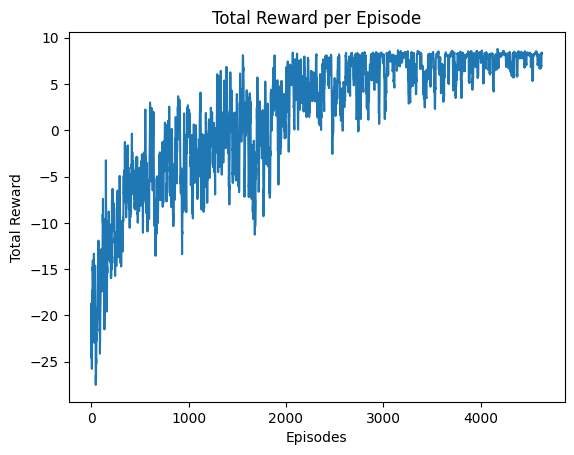

In [13]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [17]:
np.max(rewards)

np.float64(10.0)

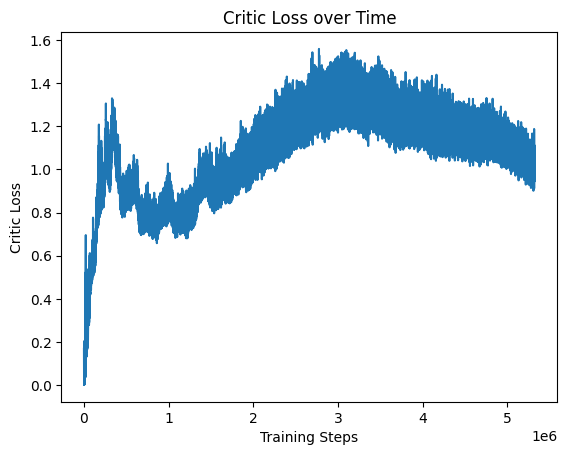

In [14]:
plt.plot(moving_average(critic_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Critic Loss')
plt.title('Critic Loss over Time')
plt.show()

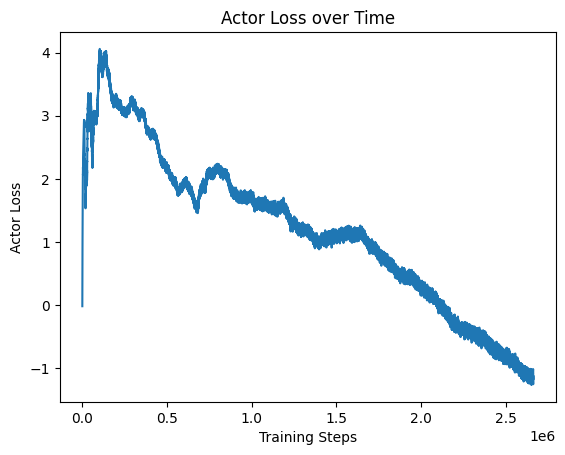

In [15]:
plt.plot(moving_average(actor_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Actor Loss')
plt.title('Actor Loss over Time')
plt.show()

In [ ]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

In [ ]:
# total_reward = 0
# state, _ = env.reset()
# for t in range(max_episode_steps):
#     env.render(mode="human")

#     done = False
#     action = agent.act(state.astype(np.float32))
#     (next_state, reward, done, trunc, _) = env.step(action)
#     state = next_state

#     total_reward += reward

#     if done or trunc:
#         break

# print(f'total_reward: {total_reward}')

In [ ]:
import time

for i in range(20):
    state, _ = env.reset()
    for t in range(max_episode_steps):
        # env.render(mode="human")

        done = False
        action = agent.act(state.astype(np.float32))
        (next_state, reward, done, trunc, _) = env.step(action)
        state = next_state

        if done or trunc:
            print(reward)
            break
    time.sleep(1)

-0.058253599163562174
0.0
10.0
10.0
10.0
0.0
10.0
10.0
10.0
10.0
-10.35123947393973
-0.21818764276919808
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


In [ ]:
env.close()